# Imports

In [1]:
# install additional packages if running on Emscripten
import platform

notebook_platform = platform.uname()
if notebook_platform.system == "Emscripten":
    import piplite

    await piplite.install(["openpyxl", "seaborn"])

In [2]:
from enum import Enum
import re
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

sns.set_style("ticks", {"axes.grid": True})

# Data

In [3]:
this_file = pathlib.Path().absolute()
data_dir = this_file.parent / "data"
data_dir

WindowsPath('c:/Users/Legion/workspace/tld_let_calibration/data')

In [4]:
radiation = Enum("rad_type", "proton Co60")
detector = Enum("detector", "mcp mts")

## Ingredients DF

In [5]:
df_mcp = pd.read_excel(
    data_dir / "interim" / "Wyniki_DK_IFJ.xlsx",
    sheet_name="dcpt_mcp",
    usecols="A,B,H",
    names=["filename", "maxx", "signal"],
    dtype={"filename": "string", "signal": "string", "maxx": "string"},
)

# Convert the 'MaxX' column to numeric, coerce non-numeric values to NaN
df_mcp["maxx"] = pd.to_numeric(df_mcp.maxx, errors="coerce")

# Drop rows with NaN values in the 'MaxX' column and modify the DataFrame in place
df_mcp.dropna(subset=["maxx", "filename"], inplace=True)
df_mcp.insert(loc=0, column="detector", value=detector.mcp.name)
df_mcp.insert(loc=1, column="rad_type", value=radiation.Co60.name)

# convert signal to numeric
df_mcp.signal = pd.to_numeric(df_mcp.signal, errors="coerce")

df_mcp.insert(
    loc=2,
    column="det_id",
    value=df_mcp.filename.apply(
        lambda s: int(re.search(r"(\d+)_\d+\.dat", s).group(1)) if re.search(r"(\d+)_\d+\.dat", s) else 0
    ).astype("int"),
)

df_mcp.insert(
    loc=2,
    column="exp",
    value=df_mcp.filename.apply(
        lambda s: re.search(r"^(.*?)(?=\d+_)", s).group(1) if re.search(r"^(.*?)(?=\d+_)", s) else ""
    ).astype("str"),
)

# rename 11b to 1b in column exp
df_mcp.loc[df_mcp.exp == "11b", "exp"] = "1b"

# drop maxx column
df_mcp.drop(columns=["maxx"], inplace=True)

# assign all rows with number 10 and greater rad_type proton
df_mcp.loc[df_mcp.exp != "k", "rad_type"] = radiation.proton.name
df_mcp

,detector,rad_type,exp,det_id,filename,signal
0,mcp,Co60,k,49,k49_3.dat,1172863330.5
1,mcp,Co60,k,56,k56_10.dat,1019210067.0
2,mcp,Co60,k,55,k55_9.dat,1121494540.0
3,mcp,Co60,k,54,k54_8.dat,1054091535.0
4,mcp,Co60,k,53,k53_7.dat,1116893872.0
5,mcp,Co60,k,52,k52_6.dat,1134993316.5
6,mcp,Co60,k,51,k51_5.dat,1125043524.5
7,mcp,Co60,k,50,k50_4.dat,1112272365.0
10,mcp,proton,2a,9,2a9_11.dat,1018292968.5
11,mcp,proton,2a,16,2a16_20.dat,1123204044.5


In [6]:
df_mts = pd.read_excel(
    data_dir / "interim" / "Wyniki_DK_IFJ.xlsx",
    sheet_name="dcpt_mts",
    usecols="N,O,U",
    names=["filename", "maxx", "signal"],
    dtype={"filename": "string", "signal": "string", "maxx": "string"},
)

# Convert the 'MaxX' column to numeric, coerce non-numeric values to NaN
df_mts["maxx"] = pd.to_numeric(df_mts.maxx, errors="coerce")

# Drop rows with NaN values in the 'MaxX' column and modify the DataFrame in place
df_mts.dropna(subset=["maxx", "filename", "signal"], inplace=True)
df_mts.insert(loc=0, column="detector", value=detector.mts.name)
df_mts.insert(loc=1, column="rad_type", value=radiation.Co60.name)

# convert signal to numeric
df_mts.signal = pd.to_numeric(df_mts.signal, errors="coerce")

df_mts.insert(
    loc=2,
    column="det_id",
    value=df_mts.filename.apply(
        lambda s: int(re.search(r"(\d+)_\d+\.dat", s).group(1)) if re.search(r"(\d+)_\d+\.dat", s) else 0
    ).astype("int"),
)

df_mts.insert(
    loc=2,
    column="exp",
    value=df_mts.filename.apply(
        lambda s: re.search(r"^(.*?)(?=\d+_)", s).group(1) if re.search(r"^(.*?)(?=\d+_)", s) else ""
    ).astype("str"),
)

# rename 11b to 1b in column exp
df_mts.loc[df_mts.exp == "11b", "exp"] = "1b"

# drop maxx column
df_mts.drop(columns=["maxx"], inplace=True)

# assign all rows with number 10 and greater rad_type proton
df_mts.loc[df_mts.exp != "k", "rad_type"] = radiation.proton.name
df_mts

,detector,rad_type,exp,det_id,filename,signal
8,mts,Co60,k,49,k49_4.dat,65069282.5
9,mts,Co60,k,56,k56_15.dat,65040815.0
10,mts,Co60,k,55,k55_12.dat,66545042.0
11,mts,Co60,k,54,k54_9.dat,64150063.0
12,mts,Co60,k,53,k53_8.dat,63204067.5
13,mts,Co60,k,52,k52_7.dat,64853507.0
14,mts,Co60,k,51,k51_6.dat,65313415.0
15,mts,Co60,k,50,k50_5.dat,68089866.5
18,mts,proton,2a,9,2a9_16.dat,66237712.0
19,mts,proton,2a,16,2a16_23.dat,67996944.5


In [7]:
df_proton_dose = pd.read_excel(
    data_dir / "interim" / "Wyniki_DK_IFJ.xlsx",
    sheet_name="dcpt_mts",
    usecols="H,I",
    names=["proton_dose", "exp"],
    dtype={"proton_dose": "float", "exp": "string"},
    nrows=4,
)
df_proton_dose

,proton_dose,exp
0,1.009,2a
1,0.995,1a
2,0.970,1b
3,0.779,1c


## Final

In [8]:
df = pd.concat([df_mcp, df_mts], ignore_index=True)
df

,detector,rad_type,exp,det_id,filename,signal
0,mcp,Co60,k,49,k49_3.dat,1172863330.5
1,mcp,Co60,k,56,k56_10.dat,1019210067.0
2,mcp,Co60,k,55,k55_9.dat,1121494540.0
3,mcp,Co60,k,54,k54_8.dat,1054091535.0
4,mcp,Co60,k,53,k53_7.dat,1116893872.0
...,...,...,...,...,...,...
74,mts,proton,1c,29,1c29_58.dat,48587863.0
75,mts,proton,1c,28,1c28_57.dat,47167339.0
76,mts,proton,1c,27,1c27_56.dat,48134805.5
77,mts,proton,1c,26,1c26_55.dat,47316639.5


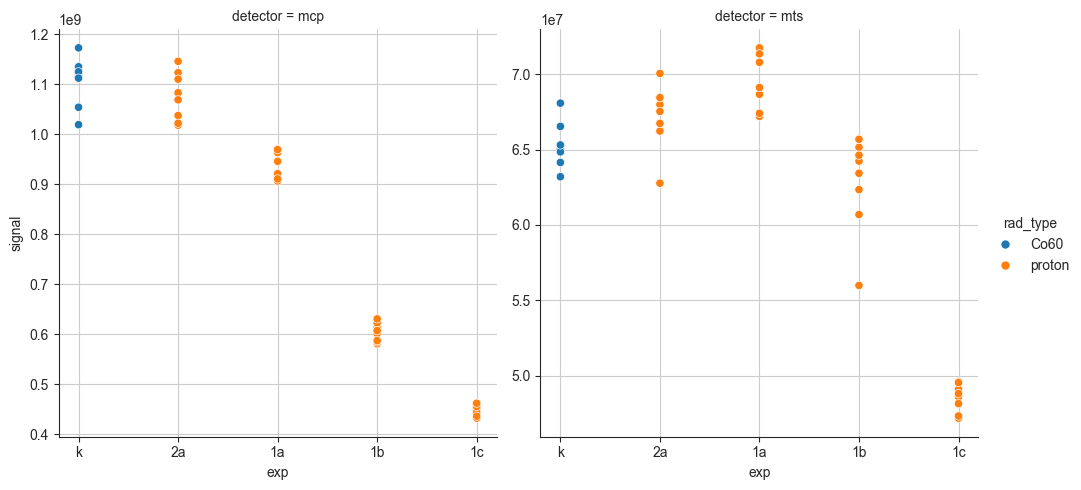

In [9]:
sns.relplot(
    data=df,
    x="exp",
    y="signal",
    hue="rad_type",
    col="detector",
    kind="scatter",
    facet_kws=dict(sharex=True, sharey=False),
)

In [10]:
dose_Co60 = 1
for name, df_group in df.groupby(["detector", "exp"]):
    det_name = name[0]
    exp_name = name[1]
    if exp_name == "k":
        continue
    dose_proton_Gy = df_proton_dose[df_proton_dose.exp == exp_name].proton_dose.values[0]
    mean_signal_Co60 = df[(df.rad_type == radiation.Co60.name) & (df.detector == det_name)].signal.mean()
    print(det_name, exp_name, dose_proton_Gy, mean_signal_Co60)
    eff = df_group.signal.values / dose_proton_Gy
    eff /= mean_signal_Co60 / dose_Co60
    # eff /= df_group[df_group.rad_type == radiation.Co60.name].signal.values / dose_Co60
    df.loc[
        (df.detector == det_name) & (df.exp == exp_name),
        "eff",
    ] = eff
df

mcp 1a 0.995 1107107818.8125
mcp 1b 0.97 1107107818.8125
mcp 1c 0.779 1107107818.8125
mcp 2a 1.009 1107107818.8125
mts 1a 0.995 65283257.3125
mts 1b 0.97 65283257.3125
mts 1c 0.779 65283257.3125
mts 2a 1.009 65283257.3125


,detector,rad_type,exp,det_id,filename,signal,eff
0,mcp,Co60,k,49,k49_3.dat,1172863330.5,<NA>
1,mcp,Co60,k,56,k56_10.dat,1019210067.0,<NA>
2,mcp,Co60,k,55,k55_9.dat,1121494540.0,<NA>
3,mcp,Co60,k,54,k54_8.dat,1054091535.0,<NA>
4,mcp,Co60,k,53,k53_7.dat,1116893872.0,<NA>
...,...,...,...,...,...,...,...
74,mts,proton,1c,29,1c29_58.dat,48587863.0,0.955407
75,mts,proton,1c,28,1c28_57.dat,47167339.0,0.927475
76,mts,proton,1c,27,1c27_56.dat,48134805.5,0.946499
77,mts,proton,1c,26,1c26_55.dat,47316639.5,0.930411


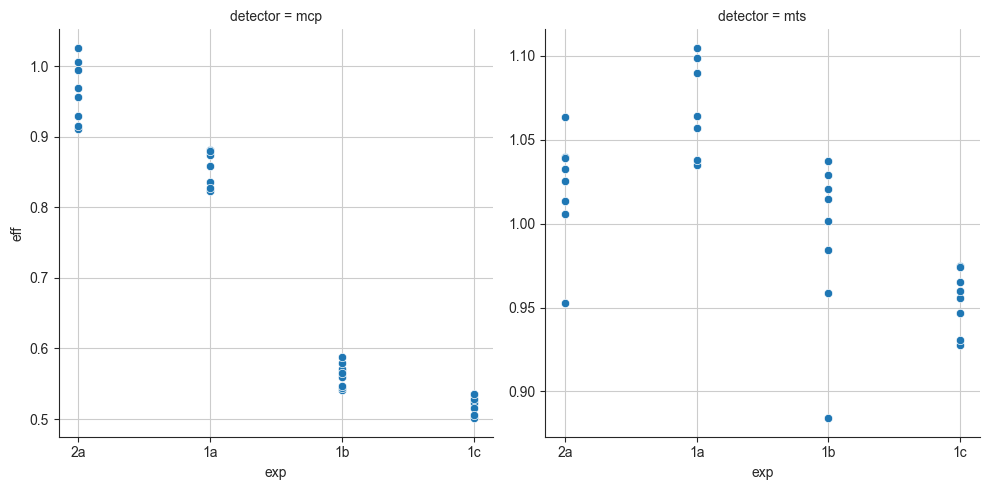

In [11]:
sns.relplot(
    data=df,
    x="exp",
    y="eff",
    col="detector",
    kind="scatter",
    facet_kws=dict(sharex=True, sharey=False),
)

In [12]:
# Assuming df is your DataFrame
# Select rows where exp is not equal to 'k'
filtered_df = df[df["exp"] != "k"]

# Group by 'exp' and 'det_id', and filter groups where both 'mcp' and 'mts' are present
selected_rows = filtered_df.groupby(["exp", "det_id", "detector"]).size().unstack()
selected_rows = selected_rows[(selected_rows["mcp"].notnull()) & (selected_rows["mts"].notnull())]

# Get the corresponding indices from the original DataFrame
df_matched = df[(df["exp"] != "k") & (df.set_index(["exp", "det_id", "detector"]).index.isin(selected_rows.index))]

# Print or use the result_df as needed
df_matched.sort_values(by=["exp", "det_id"]).reset_index(drop=True)

,detector,rad_type,exp,det_id,filename,signal,eff
0,mcp,proton,1a,1,1a1_22.dat,969326933.0,0.879949
1,mts,proton,1a,1,1a1_24.dat,71761446.0,1.104756
2,mcp,proton,1a,3,1a3_25.dat,963561397.5,0.874715
3,mts,proton,1a,3,1a3_28.dat,67416362.0,1.037864
4,mcp,proton,1a,4,1a4_26.dat,970124086.5,0.880672
...,...,...,...,...,...,...,...
57,mts,proton,2a,14,2a14_21.dat,66744894.0,1.01327
58,mcp,proton,2a,15,2a15_19.dat,1083053367.0,0.969547
59,mts,proton,2a,15,2a15_22.dat,67542217.5,1.025374
60,mcp,proton,2a,16,2a16_20.dat,1123204044.5,1.00549


In [13]:
df_matched[df_matched.exp == "1a"].sort_values(by=["det_id"])

,detector,rad_type,exp,det_id,filename,signal,eff
23,mcp,proton,1a,1,1a1_22.dat,969326933.0,0.879949
56,mts,proton,1a,1,1a1_24.dat,71761446.0,1.104756
21,mcp,proton,1a,3,1a3_25.dat,963561397.5,0.874715
62,mts,proton,1a,3,1a3_28.dat,67416362.0,1.037864
20,mcp,proton,1a,4,1a4_26.dat,970124086.5,0.880672
61,mts,proton,1a,4,1a4_29.dat,69128343.0,1.06422
19,mcp,proton,1a,5,1a5_27.dat,970666933.5,0.881165
60,mts,proton,1a,5,1a5_30.dat,68678426.5,1.057293
18,mcp,proton,1a,6,1a6_28.dat,921226434.5,0.836283
59,mts,proton,1a,6,1a6_31.dat,67210467.0,1.034694


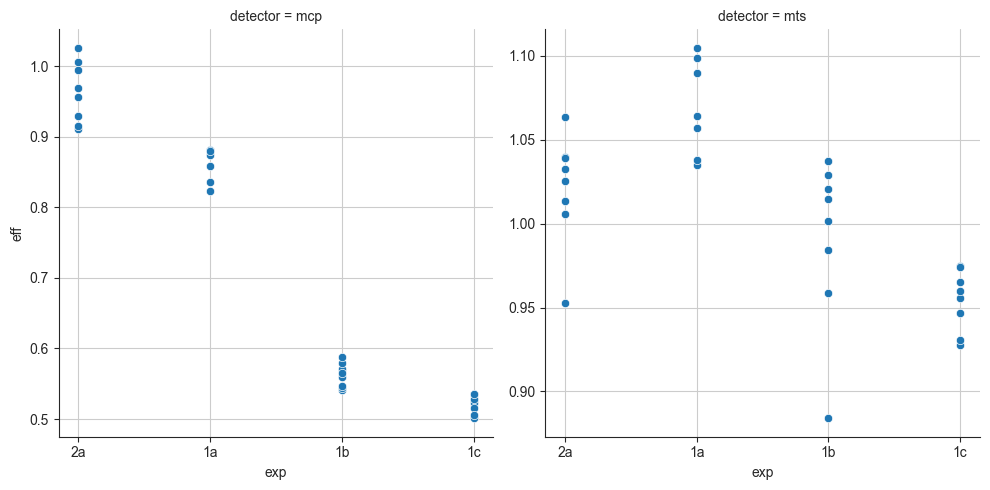

In [14]:
sns.relplot(
    data=df_matched,
    x="exp",
    y="eff",
    col="detector",
    kind="scatter",
    facet_kws=dict(sharex=True, sharey=False),
)

In [15]:
df[df.rad_type == radiation.Co60.name].groupby("detector").signal.mean()

detector
mcp    1107107818.8125
mts      65283257.3125
Name: signal, dtype: Float64

In [16]:
df_ratio = df_matched[df_matched.detector == detector.mcp.name].copy()
# drop filename
df_ratio.drop(columns=["filename", "rad_type", "detector"], inplace=True)
# rename signal to signal_mcp
df_ratio.rename(columns={"signal": "signal_mcp", "eff": "eff_mcp"}, inplace=True)

df_ratio = df_ratio.merge(
    df_matched[df_matched.detector == detector.mts.name][["exp", "det_id", "signal", "eff"]],
    how="inner",
    on=["exp", "det_id"],
)

# rename signal to signal_mts
df_ratio.rename(columns={"signal": "signal_mts", "eff": "eff_mts"}, inplace=True)

mts_mean_Co60_signal = df[(df.rad_type == radiation.Co60.name) & (df.detector == detector.mts.name)].signal.mean()
mcp_mean_Co60_signal = df[(df.rad_type == radiation.Co60.name) & (df.detector == detector.mcp.name)].signal.mean()

df_ratio["ratio_signal"] = (df_ratio.signal_mts / mts_mean_Co60_signal) / (df_ratio.signal_mcp / mcp_mean_Co60_signal)
df_ratio["ratio_eff"] = df_ratio.eff_mts / df_ratio.eff_mcp
df_ratio

,exp,det_id,signal_mcp,eff_mcp,signal_mts,eff_mts,ratio_signal,ratio_eff
0,2a,9,1018292968.5,0.911573,66237712.0,1.00557,1.103115,1.103115
1,2a,16,1123204044.5,1.00549,67996944.5,1.032277,1.026642,1.026642
2,2a,15,1083053367.0,0.969547,67542217.5,1.025374,1.057581,1.057581
3,2a,14,1037436344.0,0.928711,66744894.0,1.01327,1.09105,1.09105
4,2a,13,1068921988.5,0.956896,68501866.5,1.039943,1.086787,1.086787
5,2a,12,1110218231.0,0.993865,62773296.0,0.952976,0.958859,0.958859
6,2a,11,1145912404.0,1.025818,68454971.0,1.039231,1.013075,1.013075
7,2a,10,1022135425.5,0.915013,70060965.5,1.063612,1.1624,1.1624
8,1a,8,906699729.0,0.823096,71362431.5,1.098613,1.334733,1.334733
9,1a,7,945938402.5,0.858717,70801537.5,1.089978,1.269311,1.269311


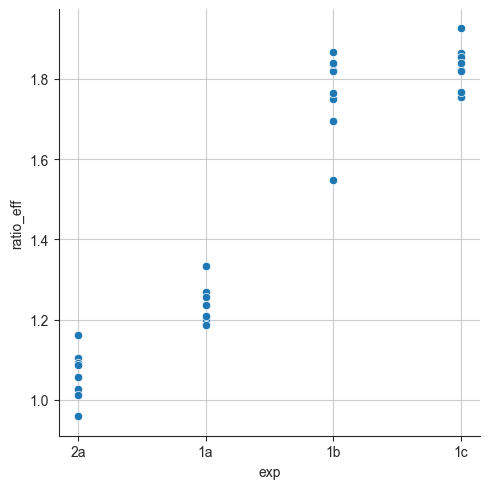

In [17]:
sns.relplot(
    data=df_ratio,
    x="exp",
    y="ratio_eff",
    kind="scatter",
)

In [18]:
df_ratio_means = df_ratio.groupby("exp").mean()
df_ratio_means.drop(columns=["det_id"], inplace=True)
df_ratio_means["ratio_signal_means"] = (df_ratio_means.signal_mts / mts_mean_Co60_signal) / (
    df_ratio_means.signal_mcp / mcp_mean_Co60_signal
)
df_ratio_means["ratio_eff_means"] = df_ratio_means.eff_mts / df_ratio_means.eff_mcp
df_ratio_means.insert(1, "signal_mcp_Co60", mcp_mean_Co60_signal)
df_ratio_means.insert(4, "signal_mts_Co60", mts_mean_Co60_signal)
df_ratio_means

,signal_mcp,signal_mcp_Co60,eff_mcp,signal_mts,signal_mts_Co60,eff_mts,ratio_signal,ratio_eff,ratio_signal_means,ratio_eff_means
exp,,,,,,,,,,
1a,949649130.928571,1.107108e+09,0.862085,69479859.071429,6.528326e+07,1.069631,1.241656,1.241656,1.240749,1.240749
1b,603646519.5625,1.107108e+09,0.56211,62772132.8125,6.528326e+07,0.991273,1.764947,1.764947,1.763487,1.763487
1c,449723419.375,1.107108e+09,0.521457,48525920.75,6.528326e+07,0.954189,1.830773,1.830773,1.829854,1.829854
2a,1076146846.625,1.107108e+09,0.963364,67289108.375,6.528326e+07,1.021532,1.062439,1.062439,1.06038,1.06038


<Axes: xlabel='exp', ylabel='ratio_eff'>

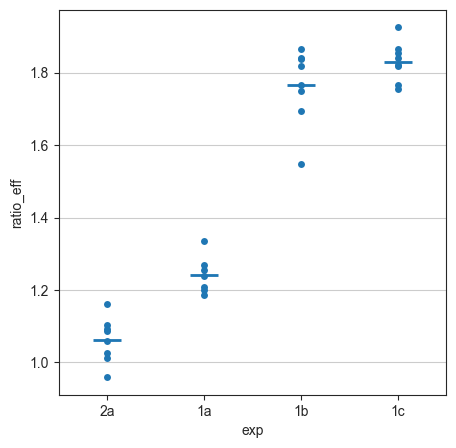

In [19]:
f, ax = plt.subplots(figsize=(5, 5))
sns.pointplot(
    data=df_ratio,
    x="exp",
    y="ratio_eff",
    linestyles="none",
    markers="_",
    markersize=20,
    errorbar=None,
    ax=ax,
)
# Add in points to show each observation
sns.stripplot(data=df_ratio, x="exp", y="ratio_eff", jitter=False, ax=ax)

# Calibration

In [20]:
df_calib_letd = pd.read_csv(
    data_dir / "raw" / "parisi_calibration" / "LETd.csv",
    decimal=",",
    sep=";",
    names=["ratio", "LETd"],
)
df_calib_letd

,ratio,LETd
0,0.954248,0.439414
1,0.990196,0.519308
2,1.031046,0.619174
3,1.050654,0.679095
4,1.071895,0.778961
...,...,...
57,3.159999,26.316504
58,3.171456,27.030287
59,3.182711,27.726410
60,3.194470,28.436907


In [21]:
df_calib_letf = pd.read_csv(
    data_dir / "raw" / "parisi_calibration" / "LETf.csv",
    decimal=",",
    sep=";",
    names=["ratio", "LETf"],
)
df_calib_letf

,ratio,LETf
0,0.950291,0.180608
1,0.970618,0.225784
2,0.992793,0.263431
3,1.033446,0.398959
4,1.059317,0.489311
...,...,...
94,3.188087,23.190316
95,3.193630,23.574313
96,3.206566,24.485365
97,3.201022,24.003486


<Axes: xlabel='LETf', ylabel='ratio'>

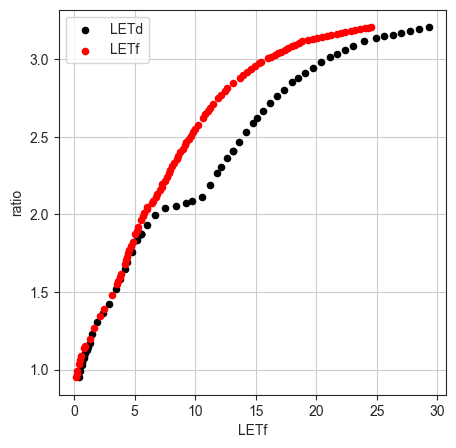

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))
df_calib_letd.plot(x="LETd", y="ratio", kind="scatter", ax=ax, label="LETd", color="black")
df_calib_letf.plot(x="LETf", y="ratio", kind="scatter", ax=ax, label="LETf", color="red")

<Axes: xlabel='ratio', ylabel='LETf'>

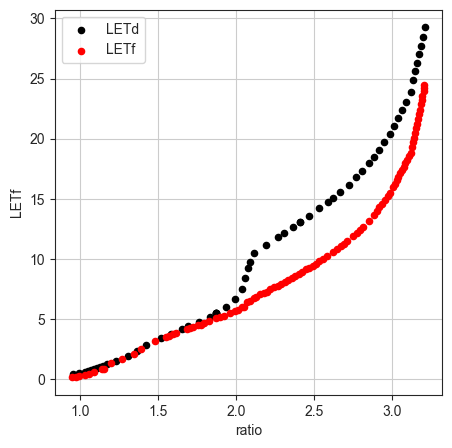

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))
df_calib_letd.plot(x="ratio", y="LETd", kind="scatter", ax=ax, label="LETd", color="black")
df_calib_letf.plot(x="ratio", y="LETf", kind="scatter", ax=ax, label="LETf", color="red")

In [24]:
calib_LETf_interp = scipy.interpolate.interp1d(df_calib_letf.ratio, df_calib_letf.LETf, kind="linear")
calib_LETd_interp = scipy.interpolate.interp1d(df_calib_letd.ratio, df_calib_letd.LETd, kind="linear")
calib_LETf_interp(2.5), calib_LETd_interp(2.5)

(array(9.54322842), array(13.903762))

## Application

In [25]:
df_mc = pd.DataFrame(
    {"exp": ["1a", "1b", "1c", "2a"], "LETf_p": [1.14, 4.39, 5.68, 0.58], "LETd_p": [2.01, 7.55, 10.1, 0.9]}
)
df_mc

,exp,LETf_p,LETd_p
0,1a,1.14,2.01
1,1b,4.39,7.55
2,1c,5.68,10.10
3,2a,0.58,0.90


In [26]:
df_ratio_means

,signal_mcp,signal_mcp_Co60,eff_mcp,signal_mts,signal_mts_Co60,eff_mts,ratio_signal,ratio_eff,ratio_signal_means,ratio_eff_means
exp,,,,,,,,,,
1a,949649130.928571,1.107108e+09,0.862085,69479859.071429,6.528326e+07,1.069631,1.241656,1.241656,1.240749,1.240749
1b,603646519.5625,1.107108e+09,0.56211,62772132.8125,6.528326e+07,0.991273,1.764947,1.764947,1.763487,1.763487
1c,449723419.375,1.107108e+09,0.521457,48525920.75,6.528326e+07,0.954189,1.830773,1.830773,1.829854,1.829854
2a,1076146846.625,1.107108e+09,0.963364,67289108.375,6.528326e+07,1.021532,1.062439,1.062439,1.06038,1.06038


In [27]:
df_ratio_means["LETf"] = calib_LETf_interp(df_ratio_means.ratio_signal.values.astype("float"))
df_ratio_means["LETd"] = calib_LETd_interp(df_ratio_means.ratio_signal.values.astype("float"))
df_ratio_means

,signal_mcp,signal_mcp_Co60,eff_mcp,signal_mts,signal_mts_Co60,eff_mts,ratio_signal,ratio_eff,ratio_signal_means,ratio_eff_means,LETf,LETd
exp,,,,,,,,,,,,
1a,949649130.928571,1.107108e+09,0.862085,69479859.071429,6.528326e+07,1.069631,1.241656,1.241656,1.240749,1.240749,1.539646,1.563844
1b,603646519.5625,1.107108e+09,0.56211,62772132.8125,6.528326e+07,0.991273,1.764947,1.764947,1.763487,1.763487,4.525159,4.792364
1c,449723419.375,1.107108e+09,0.521457,48525920.75,6.528326e+07,0.954189,1.830773,1.830773,1.829854,1.829854,4.865905,5.197603
2a,1076146846.625,1.107108e+09,0.963364,67289108.375,6.528326e+07,1.021532,1.062439,1.062439,1.06038,1.06038,0.502032,0.734501


In [28]:
df_ratio_means[["signal_mcp", "signal_mcp_Co60", "signal_mts", "signal_mts_Co60", "ratio_signal", "LETf", "LETd"]]

,signal_mcp,signal_mcp_Co60,signal_mts,signal_mts_Co60,ratio_signal,LETf,LETd
exp,,,,,,,
1a,949649130.928571,1.107108e+09,69479859.071429,6.528326e+07,1.241656,1.539646,1.563844
1b,603646519.5625,1.107108e+09,62772132.8125,6.528326e+07,1.764947,4.525159,4.792364
1c,449723419.375,1.107108e+09,48525920.75,6.528326e+07,1.830773,4.865905,5.197603
2a,1076146846.625,1.107108e+09,67289108.375,6.528326e+07,1.062439,0.502032,0.734501


In [29]:
df_ratio["LETf"] = calib_LETf_interp(df_ratio.ratio_signal.values.astype("float"))
df_ratio["LETd"] = calib_LETd_interp(df_ratio.ratio_signal.values.astype("float"))
df_ratio

,exp,det_id,signal_mcp,eff_mcp,signal_mts,eff_mts,ratio_signal,ratio_eff,LETf,LETd
0,2a,9,1018292968.5,0.911573,66237712.0,1.00557,1.103115,1.103115,0.676053,0.924994
1,2a,16,1123204044.5,1.00549,67996944.5,1.032277,1.026642,1.026642,0.376274,0.608407
2,2a,15,1083053367.0,0.969547,67542217.5,1.025374,1.057581,1.057581,0.483249,0.711662
3,2a,14,1037436344.0,0.928711,66744894.0,1.01327,1.09105,1.09105,0.619873,0.871367
4,2a,13,1068921988.5,0.956896,68501866.5,1.039943,1.086787,1.086787,0.601241,0.851774
5,2a,12,1110218231.0,0.993865,62773296.0,0.952976,0.958859,0.958859,0.199649,0.449661
6,2a,11,1145912404.0,1.025818,68454971.0,1.039231,1.013075,1.013075,0.331047,0.575241
7,2a,10,1022135425.5,0.915013,70060965.5,1.063612,1.1624,1.1624,0.999337,1.232248
8,1a,8,906699729.0,0.823096,71362431.5,1.098613,1.334733,1.334733,2.091033,2.118675
9,1a,7,945938402.5,0.858717,70801537.5,1.089978,1.269311,1.269311,1.669794,1.708295


<Axes: xlabel='exp', ylabel='LETf'>

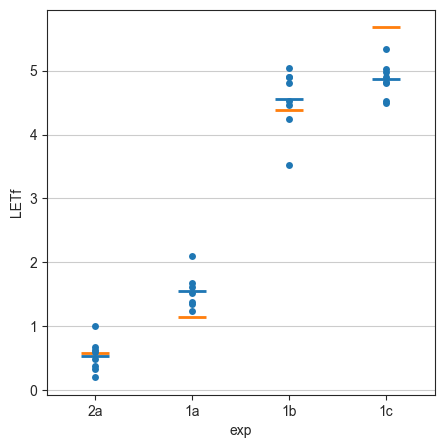

In [30]:
f, ax = plt.subplots(figsize=(5, 5))
sns.pointplot(
    data=df_ratio,
    x="exp",
    y="LETf",
    linestyles="none",
    markers="_",
    markersize=20,
    errorbar=None,
    ax=ax,
)
# Add in points to show each observation
sns.stripplot(data=df_ratio, x="exp", y="LETf", jitter=False, ax=ax)
sns.pointplot(data=df_mc, x="exp", y="LETf_p", linestyles="none", markers="_", markersize=20, errorbar=None, ax=ax)

<Axes: xlabel='exp', ylabel='LETd'>

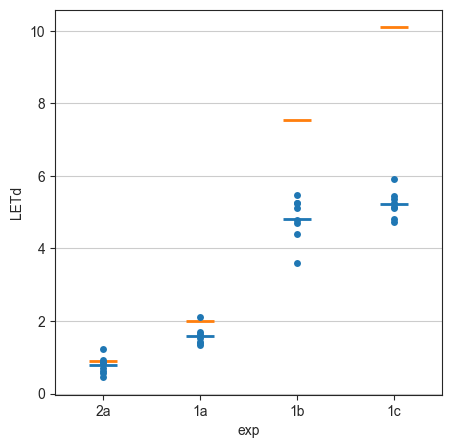

In [31]:
f, ax = plt.subplots(figsize=(5, 5))
sns.pointplot(
    data=df_ratio,
    x="exp",
    y="LETd",
    linestyles="none",
    markers="_",
    markersize=20,
    errorbar=None,
    ax=ax,
)
# Add in points to show each observation
sns.stripplot(data=df_ratio, x="exp", y="LETd", jitter=False, ax=ax)
sns.pointplot(data=df_mc, x="exp", y="LETd_p", linestyles="none", markers="_", markersize=20, errorbar=None, ax=ax)

Text(0, 0.5, 'LET [keV/um]')

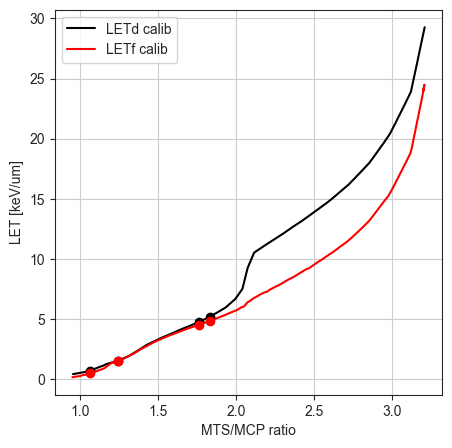

In [32]:
fig, ax = plt.subplots(figsize=(5, 5))
df_calib_letd.plot(x="ratio", y="LETd", kind="line", ax=ax, label="LETd calib", color="black")
df_calib_letf.plot(x="ratio", y="LETf", kind="line", ax=ax, label="LETf calib", color="red")
ax.plot(
    df_ratio_means.ratio_signal_means, df_ratio_means.LETd, label="LETd", color="black", marker="o", linestyle="none"
)
ax.plot(df_ratio_means.ratio_signal_means, df_ratio_means.LETf, label="LETf", color="red", marker="o", linestyle="none")
ax.set_xlabel("MTS/MCP ratio")
ax.set_ylabel("LET [keV/um]")

(0.0, 8.0)

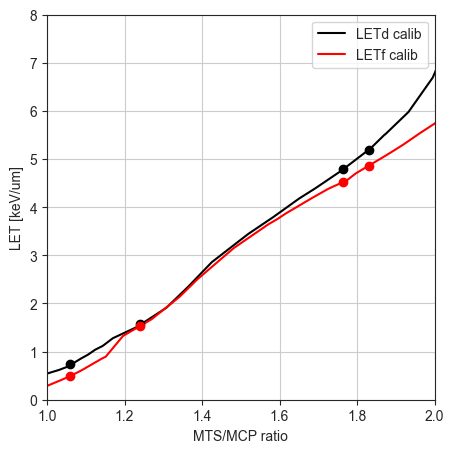

In [33]:
fig, ax = plt.subplots(figsize=(5, 5))
df_calib_letd.plot(x="ratio", y="LETd", kind="line", ax=ax, label="LETd calib", color="black")
df_calib_letf.plot(x="ratio", y="LETf", kind="line", ax=ax, label="LETf calib", color="red")
ax.plot(
    df_ratio_means.ratio_signal_means, df_ratio_means.LETd, label="LETd", color="black", marker="o", linestyle="none"
)
ax.plot(df_ratio_means.ratio_signal_means, df_ratio_means.LETf, label="LETf", color="red", marker="o", linestyle="none")
ax.set_xlabel("MTS/MCP ratio")
ax.set_ylabel("LET [keV/um]")
ax.set_xlim(1, 2)
ax.set_ylim(0, 8)